# Box Elder County Control Total Split

- Datasets
    - household (hh) data is from ACS, block group
    - population data is from ACS, block group
    - employment from LODES, block level
- Steps
    - obtain census data for all avaiable years [x]
    - obtain census block and block group shapefiles [x]
    - Establish which blocks belong REMM modeling space [x]
    - use decennial census to create ratios for block group to block distribution, not perfect but all we have
        - what percentage of block groups population reside within each block?
        - not necessary for jobs


In [31]:
import arcpy
from arcpy import env
import os
import numpy as np
from arcgis import GIS
from arcgis.features import GeoAccessor
from arcgis.features import GeoSeriesAccessor
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

arcpy.env.overwriteOutput = True
arcpy.env.parallelProcessingFactor = "90%"

# show all columns
pd.options.display.max_columns = None

# pd.pivot_table(df, values='a', index='b', columns='c', aggfunc='sum', fill_value=0)
# pd.DataFrame.spatial.from_featureclass(???)  
# df.spatial.to_featureclass(location=???,sanitize_columns=False)  

# gsa = arcgis.features.GeoSeriesAccessor(df['SHAPE'])  
# df['AREA'] = gsa.area  # KNOW YOUR UNITS

In [32]:
# fill NA values in Spatially enabled dataframes (ignores SHAPE column)
def fill_na_sedf(df_with_shape_column, fill_value=0):
    if 'SHAPE' in list(df_with_shape_column.columns):
        df = df_with_shape_column.copy()
        shape_column = df['SHAPE'].copy()
        del df['SHAPE']
        return df.fillna(fill_value).merge(shape_column,left_index=True, right_index=True, how='inner')
    else:
        raise Exception("Dataframe does not include 'SHAPE' column")

In [33]:
outputs = ['.\\Outputs', "scratch.gdb", 'results.gdb']

if not os.path.exists(outputs[0]):
    os.makedirs(outputs[0])

gdb = os.path.join(outputs[0], outputs[1])
gdb2 = os.path.join(outputs[0], outputs[2])

if not arcpy.Exists(gdb):
    arcpy.CreateFileGDB_management(outputs[0], outputs[1])

if not arcpy.Exists(gdb2):
    arcpy.CreateFileGDB_management(outputs[0], outputs[2])

## Read in Inputs

In [34]:
# lodes workplaces data - LEHD - block level
# households & population - acs 5 year - block group

# block groups
block_groups = r'.\Inputs\Boundaries\block_group_2024_utm12N.shp'

# blocks
blocks = r'.\Inputs\Boundaries\block_2024_utm12N.shp'
blocks_sdf = pd.DataFrame.spatial.from_featureclass(blocks)  

# TAZ
# taz = r'E:\Data\Boundaries\WFv910_TAZ_MAG_Update.shp'
taz_be = r'.\Inputs\Boundaries\box_elder_remm'

## Calculate HH Block / Block Group Ratio

In [35]:
# get a ratio of households in each block from its respective block group
census_hh_2020 = r"E:\Tasks\Box-Elder-County-Split\Inputs\Households\DECENNIALDHC2020.P16-Data.csv"
census_hh_2020_df = pd.read_csv(census_hh_2020)
census_hh_2020_df.rename({'Geography':'Block_ID', ' !!Total:':'HH20'}, axis=1, inplace=True)
census_hh_2020_df['BlockGroup_ID'] = census_hh_2020_df['Block_ID'].str[9:21]
bg_sum  = census_hh_2020_df.groupby('BlockGroup_ID', as_index=False)[['HH20']].sum()
bg_sum.rename({'HH20':'HH20_BG'}, axis=1, inplace=True)
hh20 = census_hh_2020_df[['Block_ID', 'BlockGroup_ID', 'HH20']].merge(bg_sum, on='BlockGroup_ID', how='left')
hh20['HH_RATIO'] = (hh20['HH20'] / hh20['HH20_BG']).fillna(0)
hh20_ratio = blocks_sdf.merge(hh20, left_on='GEOIDFQ20', right_on='Block_ID', how='left')[['STATEFP20','COUNTYFP20','TRACTCE20','BLOCKCE20','GEOID20','GEOIDFQ20', 'HH_RATIO', 'SHAPE']]
# hh20_ratio.spatial.to_featureclass(location=os.path.join(gdb, 'HH20_Ratio_Block'),sanitize_columns=False)

In [36]:
hh20_ratio.head(2)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,GEOIDFQ20,HH_RATIO,SHAPE
0,49,003,960100,3358,490039601003358,1000000US490039601003358,0.000000,"{""rings"": [[[353876.0439295139, 4596039.097365..."
1,49,003,960400,1053,490039604001053,1000000US490039604001053,0.018998,"{""rings"": [[[375784.0301679105, 4602203.222448..."


##  Calculate Pop Block / Block Group Ratio

In [37]:
# get a ratio of population in each block from its respective block group
census_pop_2020 = r"E:\Tasks\Box-Elder-County-Split\Inputs\Households\DECENNIALDHC2020.P1-Data.csv"
census_pop_2020_df = pd.read_csv(census_pop_2020)
census_pop_2020_df.rename({'Geography':'Block_ID', ' !!Total':'POP20'}, axis=1, inplace=True)
census_pop_2020_df['BlockGroup_ID'] = census_pop_2020_df['Block_ID'].str[9:21]
bg_sum  = census_pop_2020_df.groupby('BlockGroup_ID', as_index=False)[['POP20']].sum()
bg_sum.rename({'POP20':'POP20_BG'}, axis=1, inplace=True)
pop20 = census_pop_2020_df[['Block_ID', 'BlockGroup_ID', 'POP20']].merge(bg_sum, on='BlockGroup_ID', how='left')
pop20['POP_RATIO'] = (pop20['POP20'] / pop20['POP20_BG']).fillna(0)
pop20_ratio = blocks_sdf.merge(pop20, left_on='GEOIDFQ20', right_on='Block_ID', how='left')[['STATEFP20','COUNTYFP20','TRACTCE20','BLOCKCE20','GEOID20','GEOIDFQ20', 'POP_RATIO', 'SHAPE']]
# pop20_ratio.spatial.to_featureclass(location=os.path.join(gdb, 'POP20_Ratio_Block'),sanitize_columns=False)

In [38]:
pop20_ratio.head(2)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,GEOIDFQ20,POP_RATIO,SHAPE
0,49,003,960100,3358,490039601003358,1000000US490039601003358,0.000000,"{""rings"": [[[353876.0439295139, 4596039.097365..."
1,49,003,960400,1053,490039604001053,1000000US490039604001053,0.013729,"{""rings"": [[[375784.0301679105, 4602203.222448..."


## Create Box Elder County Blocks dataset  with "REMM" Attribute

In [39]:
boxElder_blocks = arcpy.conversion.ExportFeatures(blocks, os.path.join(gdb, 'boxElder_blocks') , where_clause="""COUNTYFP20 = '003'""")
arcpy.management.AddField(boxElder_blocks, 'REMM', "LONG")

# get the blocks that overlap with the WFRC Box Elder TAZ area
boxElder_blocks_lyr = arcpy.management.SelectLayerByLocation(
    in_layer=boxElder_blocks,
    overlap_type="HAVE_THEIR_CENTER_IN",
    select_features=taz_be,
    search_distance=None,
    selection_type="NEW_SELECTION",
    invert_spatial_relationship="NOT_INVERT"
)

# if block in REMM modeling space, assign attribute 1. If not assign 0
arcpy.management.CalculateField(boxElder_blocks_lyr, 'REMM', 1,"PYTHON3")
arcpy.management.SelectLayerByAttribute(boxElder_blocks_lyr, 'SWITCH_SELECTION')
arcpy.management.CalculateField(boxElder_blocks_lyr, 'REMM', 0,"PYTHON3")



<Result 'boxElder_blocks_Layer2'>

In [40]:
boxElder_blocks_sdf = pd.DataFrame.spatial.from_featureclass(boxElder_blocks[0])

# create blockGroup id from full block id
boxElder_blocks_sdf['BlockGroup_ID'] = boxElder_blocks_sdf['GEOIDFQ20'].str[9:21]
boxElder_blocks_sdf = boxElder_blocks_sdf[['STATEFP20','COUNTYFP20','TRACTCE20','BLOCKCE20','BlockGroup_ID','GEOID20','GEOIDFQ20', 'REMM', 'SHAPE']]
boxElder_blocks_sdf.head(2)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,BlockGroup_ID,GEOID20,GEOIDFQ20,REMM,SHAPE
0,49,003,960100,3358,490039601003,490039601003358,1000000US490039601003358,0,"{""rings"": [[[353876.04389999993, 4596039.0974]..."
1,49,003,960400,1053,490039604001,490039604001053,1000000US490039604001053,0,"{""rings"": [[[375784.0301999999, 4602203.2224],..."


# Households

In [41]:
hh_base = pd.DataFrame({'REMM': [0, 1]})

# get a list of block group level HH csvs
bg_hh_list = glob.glob(os.path.join(r'E:\Tasks\Box-Elder-County-Split\Inputs\Households', 'ACSDT5Y*.B11012-Data.csv'))

for csv in bg_hh_list:
    
    # get year from csv
    year = int(os.path.basename(csv).split('Y')[1][:4])
    
    # discard earlier data points
    if year >= 2020: 
        hh_block_group = pd.read_csv(csv, skiprows=1)


        # rename to total column to Households
        if 'Estimate!!Total' in hh_block_group.columns:
            hh_block_group.rename({'Estimate!!Total': f'HH_BG_{year}'}, axis=1, inplace=True)
            hh_block_group = hh_block_group[['Geography', f'HH_BG_{year}']].copy()
        elif 'Estimate!!Total:' in hh_block_group.columns: # named differently in some tables
            hh_block_group.rename({'Estimate!!Total:': f'HH_BG_{year}'}, axis=1, inplace=True)
            hh_block_group = hh_block_group[['Geography', f'HH_BG_{year}']].copy()

        # trim block group id
        hh_block_group['Geography'] = hh_block_group['Geography'].str[9:21]

        # join data
        blocks_with_hh = boxElder_blocks_sdf.merge(hh_block_group, left_on='BlockGroup_ID', right_on='Geography', how='left')
        blocks_with_hh = blocks_with_hh.merge(hh20_ratio[['GEOID20', 'HH_RATIO']], on='GEOID20', how='left')

        # apply ratio to current year's block group household total
        blocks_with_hh[f'HH_{year}'] = blocks_with_hh[f'HH_BG_{year}'] * blocks_with_hh['HH_RATIO']

        # export to shape for qaqc
        # blocks_with_hh.spatial.to_featureclass(location=os.path.join(gdb, f'HH_{year}_Block'),sanitize_columns=False)

        # summarize by 1 and 0 
        hh_sum_by_remm = blocks_with_hh.groupby('REMM', as_index=False)[[f'HH_{year}']].sum()
        hh_base = hh_base.merge(hh_sum_by_remm, on='REMM', how='left')
    
# Transform the dataframe to long format
df_long = hh_base.melt(id_vars='REMM', var_name='Year', value_name='Households')
df_long['Year'] = df_long['Year'].str.extract(r'(\d+)').astype(int)
# df_long

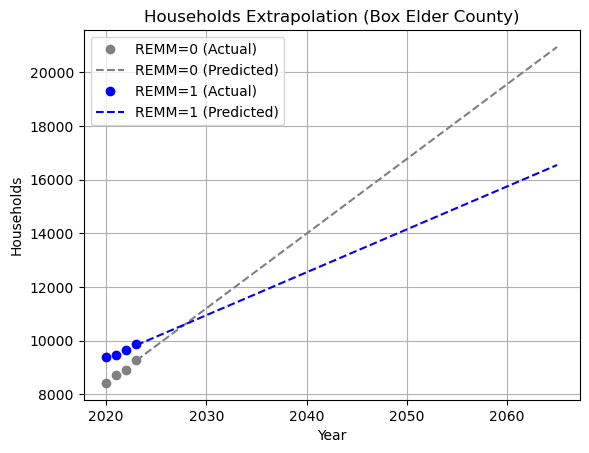

In [42]:
# Future years to predict
future_years = np.arange(2023, 2066).reshape(-1, 1)

# Fit models and predict
preds = []

color_map = {0: 'grey', 1: 'blue'}

for remm_value in [0, 1]:
    df_subset = df_long[df_long['REMM'] == remm_value]
    X = df_subset['Year'].values.reshape(-1, 1)
    y = df_subset['Households'].values
    model = LinearRegression().fit(X, y)
    
    # Predict future
    future_preds = model.predict(future_years)
    
    # Collect predictions
    preds.append(pd.DataFrame({
        'REMM': remm_value,
        'Year': future_years.flatten(),
        'Predicted_Households': future_preds
    }))

    # Optional: plot
    plt.plot(X, y, 'o', label=f'REMM={remm_value} (Actual)', color=color_map[remm_value])
    plt.plot(future_years, future_preds, '--', label=f'REMM={remm_value} (Predicted)', color=color_map[remm_value])

# Final predicted DataFrame
predicted_df = pd.concat(preds, ignore_index=True)

plt.xlabel("Year")
plt.ylabel("Households")
plt.title("Households Extrapolation (Box Elder County)")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# create table output for predicted values by year
households_predicted_by_year = pd.pivot_table(predicted_df, 'Predicted_Households', 'Year', 'REMM').reset_index()
households_predicted_by_year.rename({0:'HH_UDOT', 1:'HH_REMM'}, axis=1, inplace=True)
households_predicted_by_year["TOTAL_HH"] = households_predicted_by_year['HH_UDOT'] + households_predicted_by_year['HH_REMM']
households_predicted_by_year["HHPCT_REMM"] = households_predicted_by_year['HH_REMM'] / households_predicted_by_year["TOTAL_HH"]
households_predicted_by_year["HHPCT_UDOT"] = households_predicted_by_year['HH_UDOT'] / households_predicted_by_year["TOTAL_HH"]
households_predicted_by_year.to_csv(os.path.join(outputs[0], 'BoxElder_HH_percentage_REMM_UDOT.csv'), index=False)
households_predicted_by_year

REMM,Year,HH_UDOT,HH_REMM,TOTAL_HH,HHPCT_REMM,HHPCT_UDOT
0,2023,9257.327315,9827.672685,19085.0,0.514942,0.485058
1,2024,9535.487130,9987.512870,19523.0,0.511577,0.488423
2,2025,9813.646945,10147.353055,19961.0,0.508359,0.491641
3,2026,10091.806761,10307.193239,20399.0,0.505279,0.494721
4,2027,10369.966576,10467.033424,20837.0,0.502329,0.497671
5,2028,10648.126392,10626.873608,21275.0,0.499501,0.500499
6,2029,10926.286207,10786.713793,21713.0,0.496786,0.503214
7,2030,11204.446023,10946.553977,22151.0,0.494179,0.505821
8,2031,11482.605838,11106.394162,22589.0,0.491673,0.508327
9,2032,11760.765654,11266.234346,23027.0,0.489262,0.510738


# Population

In [44]:
pop_base = pd.DataFrame({'REMM': [0, 1]})

# get a list of block group level Population csvs
bg_pop_list = glob.glob(os.path.join(r'E:\Tasks\Box-Elder-County-Split\Inputs\Population', 'ACSDT5Y*.B01003-Data.csv'))

for csv in bg_pop_list:
    
    # get year from csv
    year = int(os.path.basename(csv).split('Y')[1][:4])

    # discard earlier data points
    if year >= 2020: 
        pop_block_group = pd.read_csv(csv, skiprows=1)

         # rename to total column to Households
        if 'Estimate!!Total' in pop_block_group.columns:
            pop_block_group.rename({'Estimate!!Total': f'POP_BG_{year}'}, axis=1, inplace=True)
            pop_block_group = pop_block_group[['Geography', f'POP_BG_{year}']].copy()
        elif 'Estimate!!Total:' in pop_block_group.columns: # named differently in some tables
            pop_block_group.rename({'Estimate!!Total:': f'POP_BG_{year}'}, axis=1, inplace=True)
            pop_block_group = pop_block_group[['Geography', f'POP_BG_{year}']].copy()

        # trim block group id
        pop_block_group['Geography'] = pop_block_group['Geography'].str[9:21]
      
        # join data
        blocks_with_pop = boxElder_blocks_sdf.merge(pop_block_group, left_on='BlockGroup_ID', right_on='Geography', how='left')
        blocks_with_pop = blocks_with_pop.merge(pop20_ratio[['GEOID20', 'POP_RATIO']], on='GEOID20', how='left')

        # apply ratio to current year's block group household total
        blocks_with_pop[f'POP_{year}'] = blocks_with_pop[f'POP_BG_{year}'] * blocks_with_pop['POP_RATIO']

        # export to shape for qaqc
        # blocks_with_pop.spatial.to_featureclass(location=os.path.join(gdb, f'POP_{year}_Block'),sanitize_columns=False)

        # summarize by 1 and 0 
        pop_sum_by_remm = blocks_with_pop.groupby('REMM', as_index=False)[[f'POP_{year}']].sum()
        pop_base = pop_base.merge(pop_sum_by_remm, on='REMM', how='left')

# Transform the dataframe to long format
df_long = pop_base.melt(id_vars='REMM', var_name='Year', value_name='Population')
df_long['Year'] = df_long['Year'].str.extract(r'(\d+)').astype(int)
# df_long

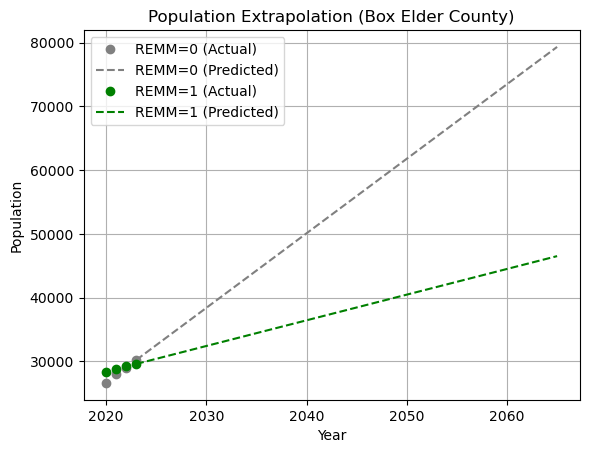

In [45]:
# Future years to predict
future_years = np.arange(2023, 2066).reshape(-1, 1)

# Fit models and predict
preds = []

color_map = {0: 'grey', 1: 'green'}

for remm_value in [0, 1]:
    df_subset = df_long[df_long['REMM'] == remm_value]
    X = df_subset['Year'].values.reshape(-1, 1)
    y = df_subset['Population'].values
    model = LinearRegression().fit(X, y)
    
    # Predict future
    future_preds = model.predict(future_years)
    
    # Collect predictions
    preds.append(pd.DataFrame({
        'REMM': remm_value,
        'Year': future_years.flatten(),
        'Predicted_Population': future_preds
    }))

    # Optional: plot
    plt.plot(X, y, 'o', label=f'REMM={remm_value} (Actual)', color=color_map[remm_value])
    plt.plot(future_years, future_preds, '--', label=f'REMM={remm_value} (Predicted)', color=color_map[remm_value])

# Final predicted DataFrame
predicted_df = pd.concat(preds, ignore_index=True)

plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population Extrapolation (Box Elder County)")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# create table output for predicted values by year
population_predicted_by_year = pd.pivot_table(predicted_df, 'Predicted_Population', 'Year', 'REMM').reset_index()
population_predicted_by_year.rename({0:'POP_UDOT', 1:'POP_REMM'}, axis=1, inplace=True)
population_predicted_by_year["TOTAL_POP"] = population_predicted_by_year['POP_UDOT'] + population_predicted_by_year['POP_REMM']
population_predicted_by_year["POPPCT_REMM"] = population_predicted_by_year['POP_REMM'] / population_predicted_by_year["TOTAL_POP"]
population_predicted_by_year["POPPCT_UDOT"] = population_predicted_by_year['POP_UDOT'] / population_predicted_by_year["TOTAL_POP"]
population_predicted_by_year.to_csv(os.path.join(outputs[0], 'BoxElder_POP_percentage_REMM_UDOT.csv'), index=False)
# population_predicted_by_year

# Employment

- 9 CNS01 Num Number of jobs in NAICS sector 11 (Agriculture, Forestry, Fishing and Hunting)
- 10 CNS02 Num Number of jobs in NAICS sector 21 (Mining, Quarrying, and Oil and Gas Extraction)
- 11 CNS03 Num Number of jobs in NAICS sector 22 (Utilities)
- 12 CNS04 Num Number of jobs in NAICS sector 23 (Construction)
- 13 CNS05 Num Number of jobs in NAICS sector 31-33 (Manufacturing)
- 14 CNS06 Num Number of jobs in NAICS sector 42 (Wholesale Trade)
- 15 CNS07 Num Number of jobs in NAICS sector 44-45 (Retail Trade)
- 16 CNS08 Num Number of jobs in NAICS sector 48-49 (Transportation and Warehousing)
- 17 CNS09 Num Number of jobs in NAICS sector 51 (Information)
- 18 CNS10 Num Number of jobs in NAICS sector 52 (Finance and Insurance)
- 19 CNS11 Num Number of jobs in NAICS sector 53 (Real Estate and Rental and Leasing)
- 20 CNS12 Num Number of jobs in NAICS sector 54 (Professional, Scientific, and Technical Services)
- 21 CNS13 Num Number of jobs in NAICS sector 55 (Management of Companies and Enterprises)
- 22 CNS14 Num Number of jobs in NAICS sector 56 (Administrative and Support and Waste Management and Remediation Services)
- 23 CNS15 Num Number of jobs in NAICS sector 61 (Educational Services)
- 24 CNS16 Num Number of jobs in NAICS sector 62 (Health Care and Social Assistance)
- 25 CNS17 Num Number of jobs in NAICS sector 71 (Arts, Entertainment, and Recreation)
- 26 CNS18 Num Number of jobs in NAICS sector 72 (Accommodation and Food Services)
- 27 CNS19 Num Number of jobs in NAICS sector 81 (Other Services [except Public Administration])
- 28 CNS20 Num Number of jobs in NAICS sector 92 (Public Administration)

In [47]:
def Calc_TDMSectors(lodes_df, year):
    # lodes_df[f'FOOD_{year}'] = lodes_df['CNS18']
    # lodes_df[f'OTHR_{year}'] = lodes_df['CNS14'] + lodes_df['CNS17'] + lodes_df['CNS11'] + lodes_df['CNS10'] + lodes_df['CNS19']
    # lodes_df[f'CONST_{year}'] = lodes_df['CNS04']
    # lodes_df[f'GVED_{year}'] = lodes_df['CNS15'] + lodes_df['CNS20']
    # lodes_df[f'AGRI_{year}'] = lodes_df['CNS01'] 
    # lodes_df[f'MING_{year}'] = lodes_df['CNS02'] 
    # lodes_df[f'HLTH_{year}'] = lodes_df['CNS16']
    # lodes_df[f'RETL_{year}'] = lodes_df['CNS07']
    # lodes_df[f'MANU_{year}'] = lodes_df['CNS05'] 
    # lodes_df[f'WSLE_{year}'] = lodes_df['CNS06'] + lodes_df['CNS08'] + lodes_df['CNS03']
    # lodes_df[f'OFFI_{year}'] = lodes_df['CNS13'] + lodes_df['CNS09'] + lodes_df['CNS12']

    lodes_df[f'RETL_{year}'] =  lodes_df['CNS07'] + lodes_df['CNS18']
    lodes_df[f'IND_{year}'] = lodes_df['CNS06'] + lodes_df['CNS08'] + lodes_df['CNS03'] + lodes_df['CNS05'] 
    lodes_df[f'OFFI_{year}'] = lodes_df['CNS13'] + lodes_df['CNS09'] + lodes_df['CNS12'] + lodes_df['CNS14'] + lodes_df['CNS17'] + lodes_df['CNS11'] + lodes_df['CNS10'] + lodes_df['CNS19'] + lodes_df['CNS16'] + lodes_df['CNS15'] + lodes_df['CNS20']
    lodes_df[f'TOTAL_{year}'] =   lodes_df[f'RETL_{year}'] + lodes_df[f'IND_{year}'] + lodes_df[f'OFFI_{year}']
    
    return lodes_df

In [48]:
def Process_Employment(sector):
    emp_base = pd.DataFrame({'REMM': [0, 1]})

    # get a list of block group level Population csvs
    blk_emp_list = glob.glob(os.path.join(r'E:\Tasks\Box-Elder-County-Split\Inputs\Employment', 'ut_wac_S000_JT01_*.csv'))

    for csv in blk_emp_list:
        
        # get year from csv
        year = int(os.path.basename(csv).split('_')[4].split('.')[0])

        # discard earlier data points
        if year >= 2010: 

            emp_blk = pd.read_csv(csv)
            emp_blk = Calc_TDMSectors(emp_blk, year)

            emp_blk['w_geocode'] = emp_blk['w_geocode'].astype(str)

            # join data
            blocks_with_emp = boxElder_blocks_sdf.merge(emp_blk, left_on='GEOID20', right_on='w_geocode', how='left')
            blocks_with_emp[f'{sector}_{year}'] = blocks_with_emp[f'{sector}_{year}'].fillna(0).astype('int32')

            # export to shape for qaqc
            # blocks_with_emp.spatial.to_featureclass(location=os.path.join(gdb, f'{sector}_{year}_Block'),sanitize_columns=False)

            # summarize by 1 and 0 
            emp_variable = f'{sector}_{year}'
            emp_sum_by_remm = blocks_with_emp.groupby('REMM', as_index=False)[[emp_variable]].sum()
            emp_base = emp_base.merge(emp_sum_by_remm, on='REMM', how='left')

    # Transform the dataframe to long format
    df_long = emp_base.melt(id_vars='REMM', var_name='Year', value_name=sector)
    df_long['Year'] = df_long['Year'].str.extract(r'(\d+)').astype(int)

    # Future years to predict
    future_years = np.arange(2023, 2066).reshape(-1, 1)

    # Fit models and predict
    preds = []

    color_map = {0: 'grey', 1: 'red'}

    for remm_value in [0, 1]:
        df_subset = df_long[df_long['REMM'] == remm_value]
        X = df_subset['Year'].values.reshape(-1, 1)
        y = df_subset[sector].values
        model = LinearRegression().fit(X, y)
        
        # Predict future
        future_preds = model.predict(future_years)
        
        # Collect predictions
        preds.append(pd.DataFrame({
            'REMM': remm_value,
            'Year': future_years.flatten(),
            f'Predicted_{sector}': future_preds
        }))

        # Optional: plot
        plt.plot(X, y, 'o', label=f'REMM={remm_value} (Actual)', color=color_map[remm_value])
        plt.plot(future_years, future_preds, '--', label=f'REMM={remm_value} (Predicted)', color=color_map[remm_value])

    # Final predicted DataFrame
    predicted_df = pd.concat(preds, ignore_index=True)

    plt.xlabel("Year")
    plt.ylabel(sector)
    plt.title(f"{sector} Jobs Extrapolation (Box Elder County)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # create table output for predicted values by year
    emp_predicted_by_year = pd.pivot_table(predicted_df, f'Predicted_{sector}', 'Year', 'REMM').reset_index()
    emp_predicted_by_year.rename({0:f'{sector}_UDOT', 1:f'{sector}_REMM'}, axis=1, inplace=True)
    emp_predicted_by_year[f"TOTAL_{sector}"] = emp_predicted_by_year[f'{sector}_UDOT'] + emp_predicted_by_year[f'{sector}_REMM']
    emp_predicted_by_year[f"{sector}_PCT_REMM"] = emp_predicted_by_year[f'{sector}_REMM'] / emp_predicted_by_year[f"TOTAL_{sector}"]
    emp_predicted_by_year[f"{sector}_PCT_UDOT"] = emp_predicted_by_year[f'{sector}_UDOT'] / emp_predicted_by_year[f"TOTAL_{sector}"]
    emp_predicted_by_year.to_csv(os.path.join(outputs[0], f'BoxElder_{sector}_percentage_REMM_UDOT.csv'), index=False)

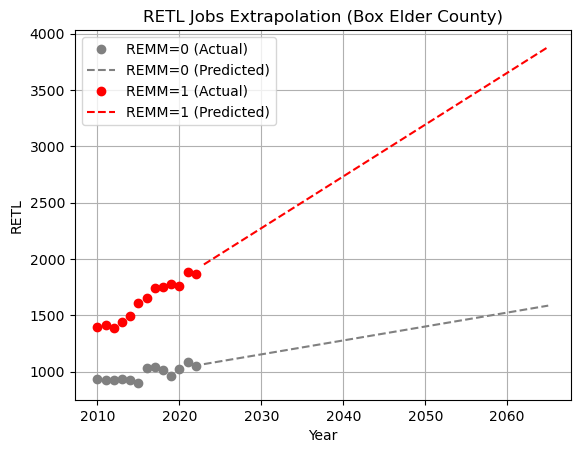

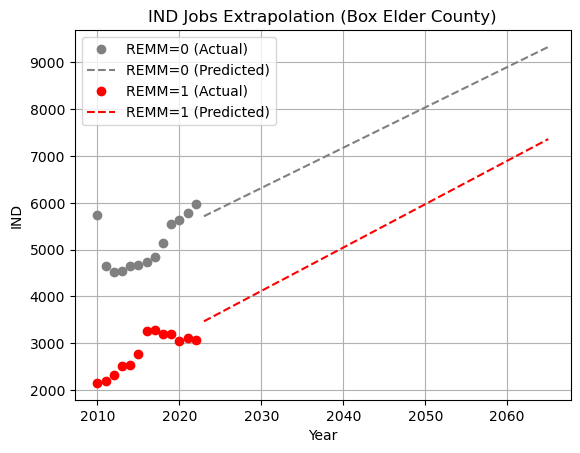

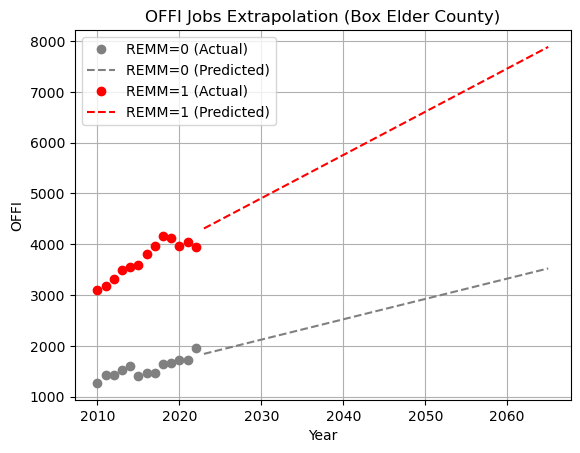

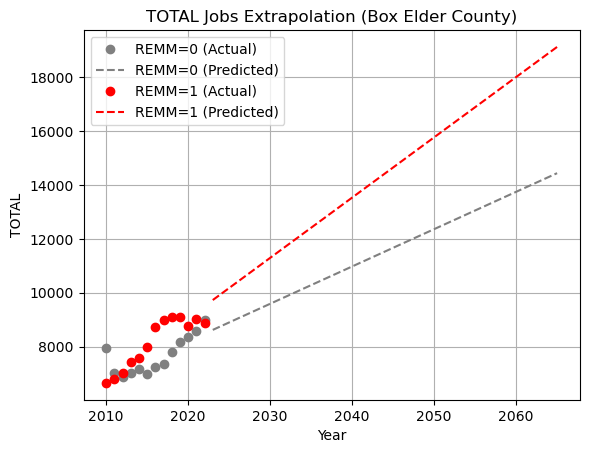

In [49]:
for sector in ['RETL', 'IND', 'OFFI', 'TOTAL']:
    Process_Employment(sector)

# Apply percentages to Control Totals